In [1]:
#Kaggleのコンペで作成したプログラム
#https://www.kaggle.com/c/tabular-playground-series-may-2021/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [76]:
#データ読み込み
train_x = pd.read_csv("train.csv")
test_x = pd.read_csv("test.csv")

train_y = train_x["target"]
test_id = test_x["id"]

train_x = train_x.drop(["id", "target"], axis=1)
test_x = test_x.drop(["id"], axis=1)


In [77]:
#欠損値の有無の確認
train_x.isna().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

In [78]:
#データの標準化
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(train_x)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [79]:
#トレーニングデータとテスト用データを標準化
col = train_x.columns
train_X = scaler.fit_transform(train_x)
train_X = pd.DataFrame(train_X, columns=col)
train_X.head()

col = test_x.columns
test_X = scaler.fit_transform(test_x)
test_X = pd.DataFrame(test_X, columns=col)
test_X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,-0.279618,-0.22124,-0.222408,-0.322172,-0.217283,-0.26661,1.383226,1.012438,-0.263498,-0.492291,4.118099,-0.398401,-0.409536,-0.211997,-0.564329,-0.118110,0.514958,-0.407637,0.483380,-0.324033,0.804112,-0.304131,-0.335125,-0.323331,-0.410336,-0.311347,3.022757,-0.189038,2.066638,-0.232001,-0.221715,-0.415154,-0.188474,-0.269111,-0.452089,-0.309805,-0.285447,-0.36434,0.188783,-0.179209,-0.411170,-0.290131,-0.226788,-0.262982,-0.214582,-0.240273,-0.240460,-0.267590,-0.374496,-0.332698
1,-0.279618,-0.22124,1.683075,-0.322172,-0.217283,-0.26661,0.533056,-0.453822,1.817284,3.166234,-0.284552,-0.398401,-0.409536,-0.211997,-0.564329,0.804480,-0.285213,-0.407637,1.396623,-0.324033,-0.259613,-0.304131,-0.335125,-0.323331,-0.410336,-0.311347,2.369010,-0.189038,0.473338,-0.232001,-0.221715,0.195726,-0.188474,1.077342,1.993000,0.698194,-0.285447,-0.36434,0.563145,-0.179209,1.304038,-0.290131,0.199169,-0.262982,-0.214582,-0.240273,0.215752,-0.267590,0.383900,0.255503
2,-0.279618,-0.22124,-0.222408,-0.322172,-0.217283,-0.26661,-0.317113,-0.453822,0.033756,-0.492291,-0.284552,-0.398401,-0.409536,-0.211997,-0.564329,-0.579405,-0.285213,-0.407637,-0.429864,4.011613,-0.259613,-0.304131,-0.335125,-0.323331,1.166333,2.722484,-0.245979,-0.189038,-0.588863,-0.232001,-0.221715,0.501166,-0.188474,-0.269111,-0.452089,-0.309805,-0.285447,1.48717,1.499050,-0.179209,-0.411170,-0.290131,-0.226788,0.165174,-0.214582,-0.240273,-0.240460,-0.267590,1.900693,-0.332698
3,-0.279618,-0.22124,-0.222408,-0.322172,-0.217283,-0.26661,-0.317113,-0.087257,0.033756,-0.492291,-0.284552,-0.398401,-0.409536,-0.211997,-0.564329,-0.118110,-0.285213,-0.407637,-0.429864,0.543096,0.804112,-0.304131,-0.335125,0.494483,-0.410336,-0.311347,0.407768,0.445701,-0.057762,-0.232001,-0.221715,-0.415154,0.490661,1.526160,-0.452089,-0.309805,-0.285447,-0.36434,-0.559941,-0.179209,-0.411170,-0.290131,-0.226788,-0.262982,-0.214582,-0.240273,2.496811,5.935877,4.934278,1.431905
4,-0.279618,-0.22124,-0.222408,-0.322172,-0.217283,-0.26661,0.107972,-0.453822,0.925520,-0.492291,-0.284552,0.579559,-0.409536,-0.211997,1.383455,-0.579405,-0.285213,-0.407637,-0.429864,-0.324033,-0.259613,1.079371,-0.335125,-0.323331,-0.410336,-0.311347,-0.245979,-0.189038,0.473338,-0.232001,-0.221715,-0.109714,0.490661,-0.269111,-0.044574,-0.309805,-0.285447,-0.36434,-0.559941,-0.179209,0.160566,-0.290131,-0.226788,-0.262982,-0.214582,-0.240273,-0.240460,-0.267590,-0.374496,-0.332698


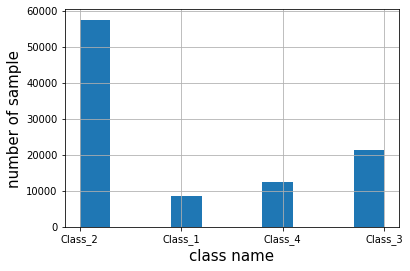

In [80]:
#分類クラスの偏りを確認
plt.hist(train_y)
plt.xlabel("class name", fontsize=15)
plt.ylabel("number of sample", fontsize=15)

plt.grid()
plt.savefig("pm1.png")
plt.show()

In [81]:
#Class_i -> (i-1)にラベルを変更
for i in range(1,5):
  train_y[train_y =='Class_' + str(i)] = str(i-1)

In [82]:
#アンダーサンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#ラベル1のデータ数が非常に大きいため, 1/3倍する. 
rus = RandomUnderSampler(sampling_strategy={'0': sum(train_y=='0'), '1': int(sum(train_y=='1')/3), '2': sum(train_y=='2'),'3': sum(train_y=='3')},
                         random_state=0)
train_X, train_y = rus.fit_resample(train_X, train_y)

#各ラベルのデータ数を均等にする
sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [83]:
# (i-1) -> Class_i にラベルを変更
for i in range(1,5):
  train_y[train_y == str(i-1)] = "Class_" + str(i) 

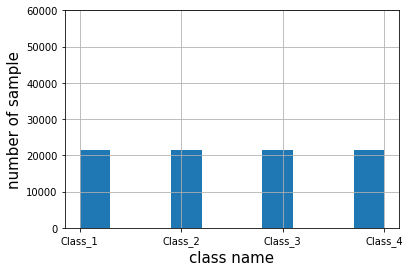

In [37]:
#サンプル数調整結果の確認
plt.hist(train_y)
plt.xlabel("class name", fontsize=15)
plt.ylabel("number of sample", fontsize=15)

plt.ylim([0, 60000])

plt.grid()
plt.savefig("pm2.png")
plt.show()

In [84]:
#線形判別分析(LDA)による次元削減
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 2)
lda.fit(train_X, train_y)

train_X = lda.transform(train_X)
test_X = lda.transform(test_X)

lda.explained_variance_ratio_

array([0.74067918, 0.22438237])

In [44]:
#xgboostによる分類
import xgboost as xgb
from sklearn.metrics import log_loss
#チューニング用のパラメータ
param = { 'n_estimator' : [50, 100, 200],
          'learning_rate': [10**(i) for i in range(-4, -1)],
          'max_depth': [3, 4, 6]
         }
num_round = 50

In [71]:
#分類器の作成とパラメータのグリッドサーチ
clf = xgb.XGBClassifier(objective = 'multi;softprob', silent=1, random_state=71)
clf_cv = GridSearchCV(clf, param, cv=5, verbose=1)
clf_cv.fit(train_X, train_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 28.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi;softprob',
                                     random_state=71, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=1,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01],
                         'max_depth': [3, 4, 6],
                         'n_estimator': [50, 100, 200]},
         

In [73]:
#チューニング後のパラメータを確認
clf_cv.best_params_

{'learning_rate': 0.001, 'max_depth': 4, 'n_estimator': 50}

In [85]:
#チューニング後のパラメータを使って分類器作成
clf = xgb.XGBClassifier(#**clf_cv.best_params_
                        learning_rate = 0.01, max_depth = 3, n_estimator = 50)
clf.fit(train_X, train_y)
clf.score(train_X, train_y)

0.31870915032679736

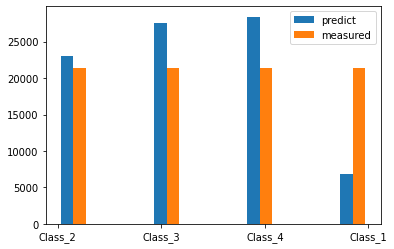

In [86]:
#テストデータと予測値のヒストグラム
ans = clf.predict(train_X)
fig = plt.figure()
ax = fig.add_subplot(1, 1 ,1)

labels = ["predict", "measured"]
ax.hist([ans, train_y], label = labels)
plt.legend()

plt.savefig("predict.png")
plt.show()

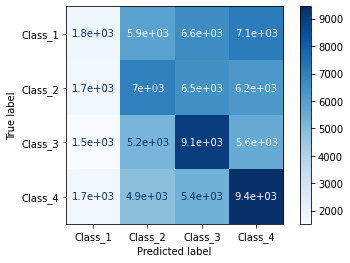

In [64]:
#予測結果のヒートマップ
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, train_X, train_y,
                      #display_labels=train_y,
                      cmap=plt.cm.Blues)

plt.savefig("hm.png")
plt.show()

In [91]:
#♯正解率とf値の確認
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print(accuracy_score(train_y, ans))
print(f1_score(train_y, ans, average=None))

0.31870915032679736
[0.12921069 0.31440733 0.3702432  0.379192  ]


In [16]:
#提出用データの作成
ans_submit = clf.predict_proba(np.array(test_X))
ans_submit = pd.DataFrame(ans_submit, columns=["Class_1", "Class_2", "Class_3", "Class_4"])

In [17]:
#提出用データのcsv化
t = pd.read_csv("test.csv")
test_id = t["id"]
ans_submit = pd.concat([test_id, ans_submit], axis=1)
ans_submit.to_csv("submission.csv", index=False)

In [18]:
#提出用データの確認用
ans_submit

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.259152,0.265734,0.232222,0.242892
1,100001,0.248148,0.259007,0.262185,0.230660
2,100002,0.247165,0.283322,0.234330,0.235182
3,100003,0.247025,0.238043,0.296137,0.218795
4,100004,0.260564,0.251980,0.226436,0.261019
...,...,...,...,...,...
49995,149995,0.241084,0.288349,0.247330,0.223237
49996,149996,0.257639,0.251871,0.210714,0.279775
49997,149997,0.246277,0.247322,0.245074,0.261326
49998,149998,0.258283,0.252501,0.211241,0.277976
